# The Stommel problem of the North Atlantic Circulation

Stommel's model of the Sub-tropical North Atlantic circulation is:

$$ r ~\Delta {\psi} + \beta ~\frac{\partial \psi}{\partial x} ~= ~ 
\frac{1}{\rho H} \left( \frac{\partial \tau_x}{\partial y} - \frac{\partial \tau_y}{\partial x} \right) $$

where:

* $\psi$ is the stream function;
* $r$ is a bottom friction coefficient;
* $\beta$ is the meridional derivative of the Coriolis factor, related to the rotation of the spheric Earth;
* $\rho$ and $H$ are water density and depth, respectively;
* $\tau_x$ and $\tau_y$ are the components of wind stress on the ocean surface.

The spatial domain $L_x \times L_y$ with the bottom-left corner at $(x,y)=(0,0)$ is an idealized, rectangular ocean representative of the Atlantic ocean between 15 and 45° North. The wind blows Westward in the Southern part of the domain (trades winds) and Eastward in the Northern part (Westerlies), so that the wind stress is modelled as:

$$ \tau_x = - \tau_0 ~\cos\left( \frac{\pi y}{L_y} \right) $$


## 0. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Define parameters and grid

In [121]:
tau_0, rfric, rho, depth, beta = 0.5, 1e-6, 1000, 3000, 1e-8
Lx, Ly = 4000, 2000
Nx, Ny = 101, 61
xdom, ydom = np.linspace(0,Lx,Nx), np.linspace(0,Ly,Ny)
ymesh, xmesh = np.meshgrid(ydom, xdom)
dx, dy = xdom[1]-xdom[0], ydom[1]-ydom[0]
alpha, gamma = 1/(dx*dx), 1/(dy*dy)
delta = 0.5*beta/rfric/dx

## 2. Wind stress

In [113]:
def windstress(x,y):
    taux = - tau_0 * np.cos(np.pi*y/Ly)
    tauy = np.zeros_like(taux)
    return taux, tauy

In [114]:
taux, tauy = windstress(xdom, ydom)

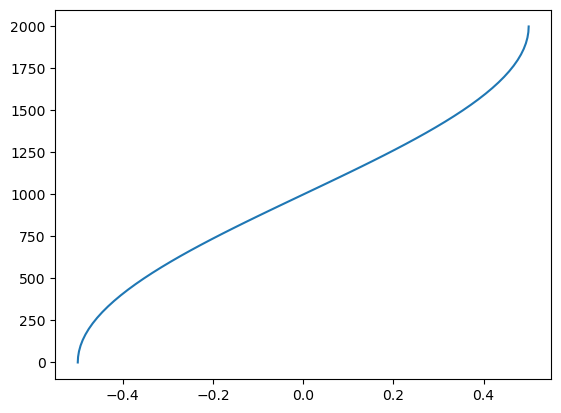

In [115]:
plt.plot(taux,ydom)

## 3. Functions


In [122]:
def build_forcing():
    """Build right-hand side term of equation"""
    forcing = np.zeros_like(xmesh)
    # Wind stress term
    taux, tauy = windstress(xmesh,ymesh)
    txdy = 0.5 * ( np.roll(taux,-1,axis=1) - np.roll(taux,1,axis=1) ) / dy
    tydx = 0.5 * ( np.roll(tauy,-1,axis=0) - np.roll(tauy,1,axis=0) ) / dx
    # forcing
    forcing = (txdy-tydx)/(rho*depth*rfric)
    forcing[0,:], forcing[-1,:], forcing[:,0], forcing[:,-1] = 0, 0, 0, 0  # not used in the algorithm
    return forcing

def solve_strf(stf, method='seidel', omega=1.5):
    """implement iteration for the stream function equation with null boundaries.
    Options: 'seidel' or 'sor'. For SOR, omega can be prescribed."""
    if method == 'seidel':
        omega = 1
    stf[:,0], stf[0,:], stf[-1,:], stf[:,-1] = 0, 0, 0, 0
    forcing = build_forcing()
    for j in range(1, Ny-1):
        for i in range(1, Nx-1):
            stf[i,j] = (1 - omega ) * stf[i,j] \
                     + ( alpha * ( stf[i-1,j] + stf[i+1,j] ) \
                     - delta * ( stf[i-1,j] - stf[i+1,j] ) \
                     +  gamma * ( stf[i,j-1] + stf[i,j+1] ) \
                     - forcing[i,j] ) * omega / ( 2 * (alpha+gamma) )
    return stf

## 4. Iterative resolution

In [117]:
strf = np.zeros_like(xmesh)    # stream function

kmax, k = 1000, 0
eps, err = 1e-10, 10
omega = 1.6   # Over-relaxation for 1<omega<2

while (k<kmax) and (err>eps):
    strf_tmp = np.copy(strf)
    strf = solve_strf(strf, method='sor', omega=omega)
    err = np.sqrt( np.mean( np.square(strf-strf_tmp) ) )
    k += 1

print(("iterations: ", k))
print(("error: ", err))

('iterations: ', 468)
('error: ', 9.640622083340008e-11)


## 5. Plot solution

In [123]:
# This function is used only for the plots
def compute_uv(strf):
    """Compute u and v from streamfunction.
    Implement a centered scheme and adherence conditions."""
    u = 0.5 * ( np.roll(strf,-1,axis=1) - np.roll(strf,1,axis=1) ) / dy
    u[0,:], u[-1,:], u[:,0], u[:,-1]  = 0, 0, 0, 0 
    v = - 0.5 * ( np.roll(strf,-1,axis=0) - np.roll(strf,1,axis=0) ) / dx
    v[0,:], v[-1,:], v[:,0], v[:,-1]  = 0, 0, 0, 0
    return u, v

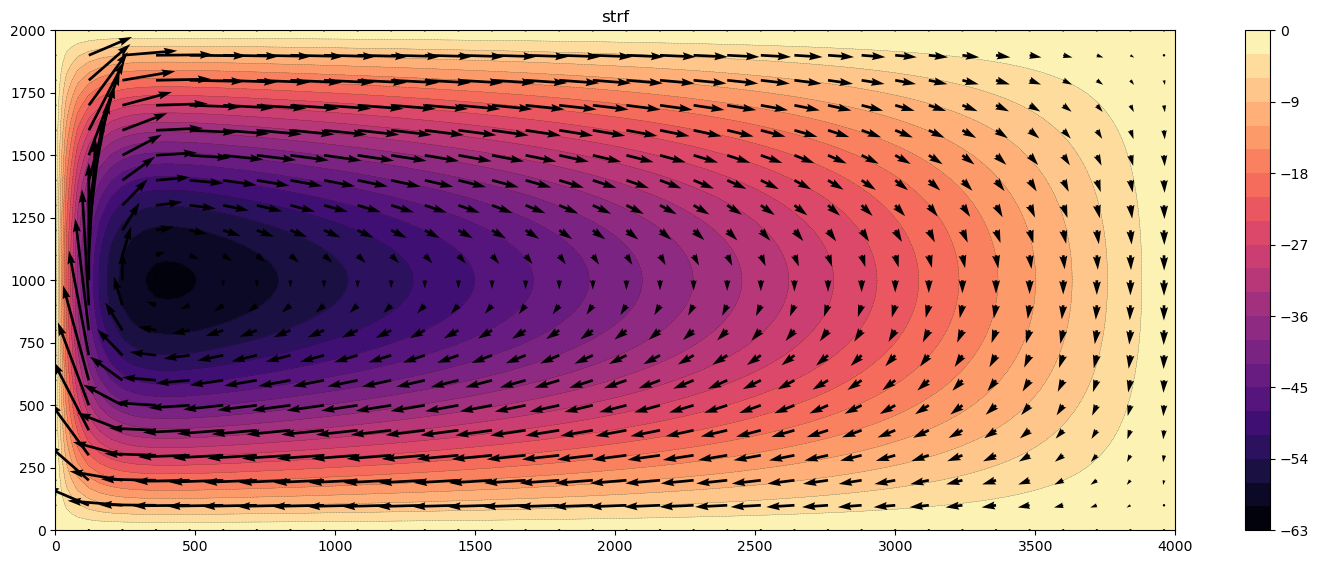

In [124]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0, 0, 1, 1])    # [left, bottom, width, height] 
#ax2 = fig.add_axes([0.57, 0, 0.43, 1])

u, v = compute_uv(strf)

vmin, vmax = -1, 1
ax1.contour(xmesh, ymesh, strf, 20, colors='black', linewidths = 0.2)
pc0=ax1.contourf(xmesh, ymesh, strf, 20, cmap = "magma")
slsp = 3  # slicing step
ax1.quiver(xmesh[::slsp,::slsp], ymesh[::slsp,::slsp], u[::slsp,::slsp], v[::slsp,::slsp])
ax1.set_title("strf")
fig.colorbar(pc0, ax=ax1)
